In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
with open('/home/ahojel/visual_prompting_vid/output_dir/improv_optimaltext_1/log.txt', 'r') as file:
    data = file.readlines()


# Convert each line from string to dictionary
data = data[1:]
data = [eval(line.strip()) for line in data]

# Create a DataFrame
df = pd.DataFrame(data)


In [38]:
df.loc[df["prompt"] == "", "prompt"] = "None"

/tmp/ipykernel_3187800/2069539542.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_3187800/2069539542.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_3187800/2069539542.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_3187800/2069539542.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_3187800/2069539542.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)


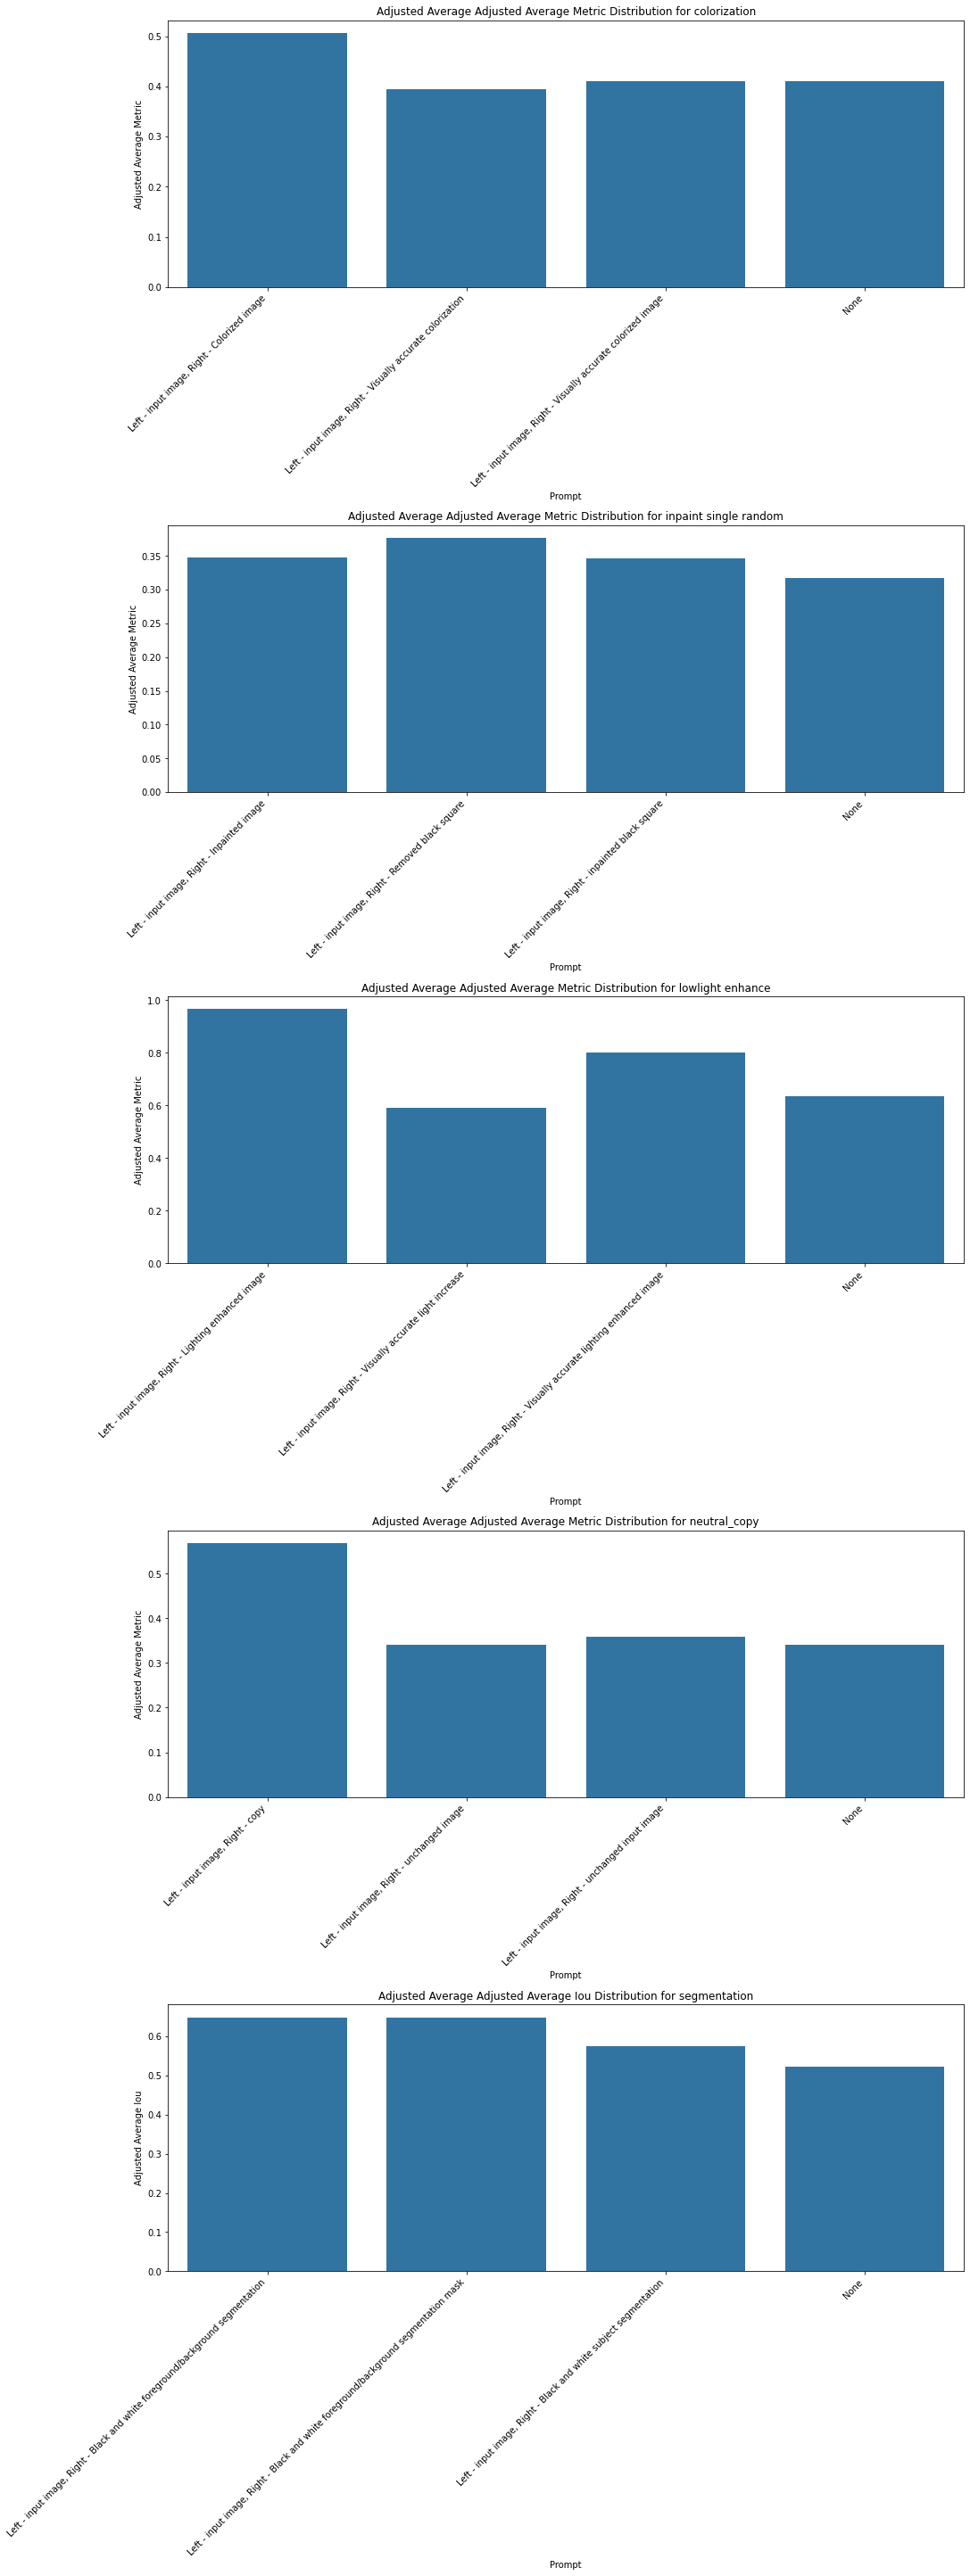

In [52]:
# Function to drop the worst 20% of performances and calculate the average of the rest
def calculate_adjusted_average(group, max=True):
    cutoff = int(len(group) * 0.3)  # Calculate the 80% cutoff point
    if max:
        top_performances = group.nlargest(cutoff)  # Select the top 80%
    else:
        top_performances = group.nsmallest(cutoff)  # Select the bottom 80%
    return top_performances.mean()  # Return the average of the selected values

# Group the data by 'task' and 'prompt' and apply the custom average function
average_data = df.groupby(['task', 'prompt'])['metric'].apply(lambda x: calculate_adjusted_average(x, max=False)).reset_index(name='adjusted_average_metric')

# Group the data by 'task' and 'prompt' and apply the custom average function for segmentation task
segmentation_data = df[df['task'] == 'segmentation'].groupby(['task', 'prompt'])['iou'].apply(lambda x: calculate_adjusted_average(x, max=True)).reset_index(name='adjusted_average_iou')

# Get unique tasks
unique_tasks = average_data['task'].unique()

# Determine the grid size for the plots
num_rows = len(unique_tasks)
fig, axs = plt.subplots(num_rows, 1, figsize=(15, 8*num_rows), constrained_layout=True)

# Create a bar plot for each task
for i, task in enumerate(unique_tasks):
    # Filter data for the current task
    if task == 'segmentation':
        task_data = segmentation_data[segmentation_data['task'] == task]
        metric = 'adjusted_average_iou'
    else:
        task_data = average_data[average_data['task'] == task]
        metric = 'adjusted_average_metric'
    
    # Plot bar plot for the current task
    sns.barplot(data=task_data, x='prompt', y=metric, ax=axs[i])
    
    # Set x-ticks labels
    prompt_labels = task_data['prompt'].unique()
    axs[i].set_xticklabels(prompt_labels, rotation=45, ha='right', fontsize=10)
 
    
    # Add plot title and labels
    axs[i].set_title(f'Adjusted Average {metric.replace("_", " ").title()} Distribution for {task}')
    axs[i].set_xlabel('Prompt')
    axs[i].set_ylabel(metric.replace("_", " ").title())

# Show the plot
plt.show()


In [106]:
# Define a function to calculate the z-score for a given series
def calculate_zscore(series):
    return (series - series.mean()) / series.std()

# Create a list to store the top 20% of each task
top_20_percent_list = []

# Iterate over each unique task to calculate the mean, std, and z-scores
for task in df['task'].unique():
    task_df = df[df['task'] == task].copy()  # Use copy to avoid SettingWithCopyWarning
    
    # Calculate z-scores for 'metric' and 'copymetric'
    task_df['metric_zscore'] = calculate_zscore(task_df['metric'])
    task_df['copymetric_zscore'] = calculate_zscore(task_df['copymetric'])
    
    # Calculate the sum of z-scores
    task_df['zscore_sum'] = task_df['metric_zscore'] + task_df['copymetric_zscore']
    
    # Select the top 20% rows based on the sum of z-scores
    cutoff = int(len(task_df) * 0.2)
    top_20_percent_task_df = task_df.nsmallest(cutoff, 'zscore_sum')


    if task == "segmentation":
        
        print(len(top_20_percent_task_df))
        top_20_percent_task_df = top_20_percent_task_df.nlargest(int(len(top_20_percent_task_df) * 0.4), 'iou')
        print(len(top_20_percent_task_df))
    
    # Append the top 20% rows to the list
    top_20_percent_list.append(top_20_percent_task_df)

# Concatenate the list of DataFrames into a single DataFrame
top_20_percent_df = pd.concat(top_20_percent_list, ignore_index=True)

# Group by 'query_name', 'support_name' and 'task' and calculate the median for numeric columns only
top_20_percent_df = top_20_percent_df.groupby(['query_name', 'support_name', 'task']).median(numeric_only=True).reset_index()

# Find the intersecting subset of all task-wise top 20% subsets
intersecting_subset = top_20_percent_df.groupby(['query_name', 'support_name']).filter(lambda x: len(x) == len(df['task'].unique()))

# Display the intersecting subset
intersecting_subset




2000
800


,query_name,support_name,task,metric,copymetric,iou,accuracy,metric_zscore,copymetric_zscore,zscore_sum
289,2007_003861,2007_000061,colorization,0.263946,0.427727,NaN,NaN,-1.299102,-0.821303,-2.120404
290,2007_003861,2007_000061,inpaint single random,0.267919,0.451314,NaN,NaN,-1.110314,-1.158944,-2.269259
291,2007_003861,2007_000061,lowlight enhance,0.535257,0.264064,NaN,NaN,-1.147213,-0.577680,-1.724893
292,2007_003861,2007_000061,segmentation,0.744343,0.427727,0.657328,0.948381,-0.788250,-0.848869,-1.637118
296,2007_003861,2007_005074,colorization,0.263948,0.427727,NaN,NaN,-1.299097,-0.821303,-2.120400
...,...,...,...,...,...,...,...,...,...,...
5915,2011_003145,2007_003682,segmentation,0.292855,0.341787,0.619970,0.979304,-1.007533,-0.964815,-1.972348
5950,2011_003145,2010_005428,colorization,0.228120,0.272314,NaN,NaN,-1.380885,-1.034048,-2.428817
5951,2011_003145,2010_005428,inpaint single random,0.404060,0.539785,NaN,NaN,-0.841678,-1.030561,-1.872239
5952,2011_003145,2010_005428,lowlight enhance,0.659746,0.169217,NaN,NaN,-0.926353,-0.826147,-1.752500


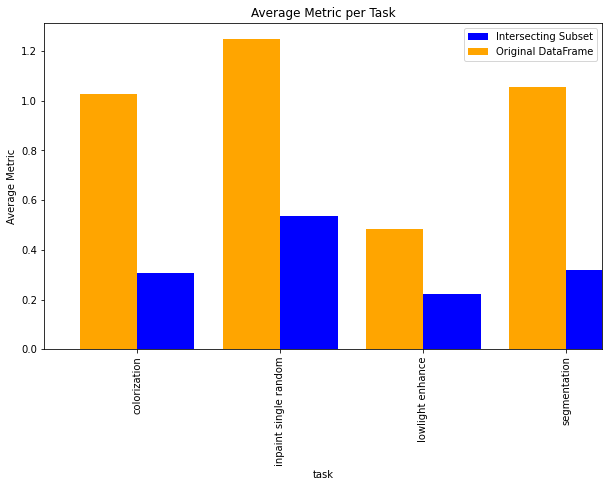

In [107]:
# Calculate average metrics for each task in the intersecting subset
intersecting_subset_task_metrics = intersecting_subset.groupby('task')['copymetric'].mean()

# Calculate average metrics for each task in the original dataframe
original_df_task_metrics = df.groupby('task')['copymetric'].mean()

# Plot average metrics for both intersecting subset and original dataframe on the same plot
plt.figure(figsize=(10, 6))
intersecting_subset_task_metrics.plot(kind='bar', color='blue', position=0, width=0.4, label='Intersecting Subset')
original_df_task_metrics.plot(kind='bar', color='orange', position=1, width=0.4, label='Original DataFrame')
plt.title('Average Metric per Task')
plt.ylabel('Average Metric')
plt.legend()
plt.show()


<AxesSubplot:>

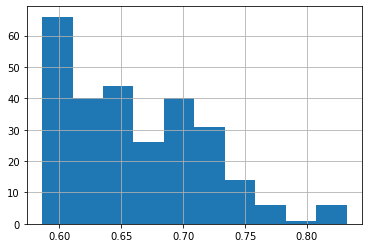

In [108]:
intersecting_subset[intersecting_subset["task"] == 'segmentation']["iou"].hist()

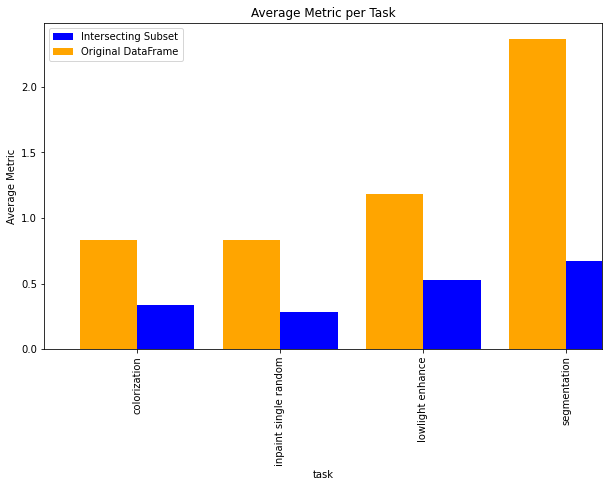

In [109]:
# Calculate average metrics for each task in the intersecting subset
intersecting_subset_task_metrics = intersecting_subset.groupby('task')['metric'].mean()

# Calculate average metrics for each task in the original dataframe
original_df_task_metrics = df.groupby('task')['metric'].mean()

# Plot average metrics for both intersecting subset and original dataframe on the same plot
plt.figure(figsize=(10, 6))
intersecting_subset_task_metrics.plot(kind='bar', color='blue', position=0, width=0.4, label='Intersecting Subset')
original_df_task_metrics.plot(kind='bar', color='orange', position=1, width=0.4, label='Original DataFrame')
plt.title('Average Metric per Task')
plt.ylabel('Average Metric')
plt.legend()
plt.show()


In [110]:
unique_pairs_dict = intersecting_subset.drop_duplicates(subset=["query_name", "support_name"])[['query_name', 'support_name']].to_dict('records')


In [111]:
len(unique_pairs_dict)

274

In [112]:
import json

with open('top_improv.json', 'w') as file:
    json.dump(unique_pairs_dict, file, indent=4)

In [ ]:
df_unique = df.drop_duplicates(subset=["query_name", "support_name"])

# Group by 'query_name' and find the one with the lowest average 'iou'
df2 = df_unique[df_unique['iou'] >= 0.2]
grouped_query = df2.groupby('query_name')['iou'].mean()
filtered_query_names = grouped_query[grouped_query >= 0.6].index
filtered_df = df2[df2['query_name'].isin(filtered_query_names)]

# Group by 'support_name' and find the one with the lowest average 'iou'
grouped_support = filtered_df.groupby('support_name')['iou'].mean()
filtered_both_names = grouped_support[grouped_support >= 0.6].index
both_filtered_df = filtered_df[filtered_df['support_name'].isin(filtered_both_names)]


In [ ]:
with open('output_dir/multi_pass/log.txt', 'r') as file:
    data2 = file.readlines()

# Convert each line from string to dictionary
data2 = [eval(line.strip()) for line in data2]

df_multi = pd.DataFrame(data2)

In [ ]:
df_multi[df_multi["support_name"].isin(both_filtered_df["support_name"])]

In [ ]:
# Group by 'query_name' and find the one with the lowest average 'iou'
df2 = df_multi[df_multi['segmentation_iou'] >= 0.2]
grouped_query = df2.groupby('query_name')['segmentation_iou'].mean()
filtered_query_names = grouped_query[grouped_query >= 0.6].index
filtered_df = df2[df2['query_name'].isin(filtered_query_names)]

# Group by 'support_name' and find the one with the lowest average 'iou'
grouped_support = filtered_df.groupby('support_name')['segmentation_iou'].mean()
filtered_both_names = grouped_support[grouped_support >= 0.6].index
both_filtered_df = filtered_df[filtered_df['support_name'].isin(filtered_both_names)]


In [ ]:
new_df = both_filtered_df[both_filtered_df['segmentation_iou'] >= 0.5]

In [ ]:
grouped_support = new_df.groupby('support_name')['inpaint_black_mse'].mean()
filtered_both_names = grouped_support[grouped_support <= 0.5].index
new_df = new_df[new_df['support_name'].isin(filtered_both_names)]

In [ ]:
grouped_support = new_df.groupby('support_name')['colorization_mse'].mean()
filtered_both_names = grouped_support[grouped_support <= 0.5].index
new_df = new_df[new_df['support_name'].isin(filtered_both_names)]

In [ ]:
grouped_support = new_df.groupby('support_name')['lowlight_mse'].mean()
filtered_both_names = grouped_support[grouped_support <= 0.5].index
new_df = new_df[new_df['support_name'].isin(filtered_both_names)]

In [ ]:
filtered_df_sorted = new_df.sort_values(by=['support_name', 'segmentation_iou'], ascending=[True, False])
df_filtered = filtered_df_sorted.drop_duplicates(subset='support_name', keep='first')

filtered_df_sorted2 = df_filtered.sort_values(by=['query_name', 'segmentation_iou'], ascending=[True, False])
df_filtered = filtered_df_sorted2.drop_duplicates(subset='query_name', keep='first')

In [ ]:
list_of_dicts = new_df[['query_name', 'support_name']].to_dict('records')

In [ ]:
import json

with open('top_multitask_pairings2.json', 'w') as file:
    json.dump(list_of_dicts, file, indent=4)